Loaded data for mg
Loaded data for si
Loaded data for fe
Loaded data for ca
Loaded data for al
Loaded data for o
Loaded data for na
Loaded data for k
Total Scattered Spectrum: [2.11526056e+09 4.66170940e+09 1.35178750e+09 ... 6.80508850e-08
 6.73634263e-08 6.66829204e-08]
Saved total scattered spectrum to /home/ka/Downloads/fv5.5.2/total_scattered_spectrum.csv


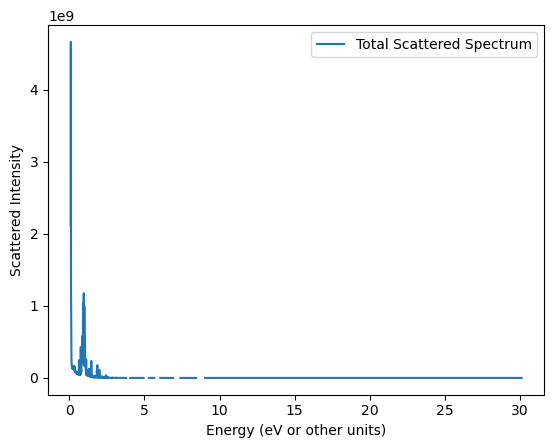

In [20]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# List of elements you want to process
selected_elements = ['mg', 'si', 'fe', 'ca', 'al', 'o', 'na', 'k']  # 'ti' removed

# Function to load and clean data from ffast text files
def load_ffast_data(file_path):
    try:
        # Read the text file into a pandas DataFrame, assuming space-separated values
        # Skip comment lines and headers with non-relevant data
        data = pd.read_csv(file_path, delim_whitespace=True, comment='#', header=None)
        
        # Skip rows where the first column is not numeric
        data = data[pd.to_numeric(data[0], errors='coerce').notnull()]
        
        # Reset index after dropping rows
        data.reset_index(drop=True, inplace=True)
        
        # Check the number of columns to determine how to handle the assignment dynamically
        num_columns = data.shape[1]
        
        # Adjust column names based on the actual number of columns in the data
        if num_columns == 14:
            data.columns = ['Energy', 'F1', 'F2', 'MuRho', 'SigmaRho', 'Column6', 'Column7', 'Column8', 'Column9', 'Column10', 'Column11', 'Column12', 'Column13', 'Column14']
        elif num_columns == 13:
            data.columns = ['Energy', 'F1', 'F2', 'MuRho', 'SigmaRho', 'Column6', 'Column7', 'Column8', 'Column9', 'Column10', 'Column11', 'Column12', 'Column13']
        else:
            print(f"Unexpected column count in {file_path}. Skipping this file.")
            return None
        
        # Filter out unnecessary columns (columns with NaN or irrelevant data)
        data = data[['Energy', 'F1', 'F2', 'MuRho', 'SigmaRho']].dropna()
        
        # Convert columns to numeric (for later calculations)
        data = data.apply(pd.to_numeric, errors='coerce')
        
        return data
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return None

# Function to interpolate SigmaRho for given energies
def interpolate_cross_section(data, energies):
    """
    Interpolates the SigmaRho values from the ffast data for the given energies.
    """
    # Create an interpolation function for SigmaRho based on Energy
    interpolation_function = interp1d(data['Energy'], data['SigmaRho'], kind='linear', fill_value='extrapolate')
    
    # Interpolate the SigmaRho values for the given energies
    interpolated_sigma_rho = interpolation_function(energies)
    
    return interpolated_sigma_rho

# Atomic mass dictionary (to convert abundance and density into number density)
atomic_masses = {
    'mg': 24.305, 'si': 28.085, 'fe': 55.845, 'ca': 40.078, 'al': 26.982, 'o': 15.999, 'na': 22.990, 'k': 39.098
}

# Model for calculating the scattered spectrum with element densities and abundances
def model_scattered_spectrum_with_density(ffast_data_dict, incident_spectrum, energies, element_properties):
    total_scattered_spectrum = np.zeros_like(incident_spectrum)

    # Loop through each element and calculate its contribution
    for element, properties in element_properties.items():
        abundance = properties['abundance']
        density = properties['density']
        
        # Get the cross-section data for the element
        if element in ffast_data_dict:
            element_data = ffast_data_dict[element]
            
            # Interpolate SigmaRho for the element at the incident energies
            sigma_rho_interpolated = interpolate_cross_section(element_data, energies)
            
            # Get the atomic mass for the element
            atomic_mass = atomic_masses.get(element, 1)  # Default to 1 if not found (this should not happen)
            
            # Calculate number density (abundance * density / atomic mass)
            number_density = abundance * density / atomic_mass
            
            # Calculate the element's contribution to the scattered spectrum
            element_scattered_spectrum = number_density * sigma_rho_interpolated * incident_spectrum
            
            # Add the element's scattered spectrum to the total scattered spectrum
            total_scattered_spectrum += element_scattered_spectrum
        else:
            print(f"Data not available for element: {element}")
    
    return total_scattered_spectrum

# Function to load the incident spectrum data from file
def load_incident_spectrum(file_path):
    try:
        # Read the file assuming space-separated values
        incident_data = pd.read_csv(file_path, delim_whitespace=True, header=None)
        
        # Extract the energy (first column) and incident intensity (third column)
        incident_data.columns = ['Energy', 'Column2', 'Intensity']
        
        # Drop the second column since it's all zeros (not needed)
        incident_data = incident_data.drop(columns=['Column2'])
        
        # Convert the data to numeric values (in case of any parsing issues)
        incident_data = incident_data.apply(pd.to_numeric, errors='coerce')
        
        return incident_data[['Energy', 'Intensity']]
    
    except Exception as e:
        print(f"Error reading incident file {file_path}: {e}")
        return None

# Main section to process ffast data and calculate total scattered spectrum
def main():
    # Path to the folder where ffast data files are located
    folder_path = '/home/ka/Downloads/Inter-IIT/X2ABUND_LMODEL_V1/data_constants/ffast'  # Update this with the actual folder path

    # Dictionary to store data for the selected elements
    ffast_data_dict = {}

    # Load data for all selected elements
    for element in selected_elements:
        atomic_number_map = {
            'mg': 12, 'si': 14, 'fe': 26, 'ca': 20, 'al': 13, 'o': 8, 'na': 11, 'k': 19
        }

        atomic_number = atomic_number_map[element]
        file_name = f"ffast_{atomic_number}_{element}.txt"  # New naming convention
        file_path = os.path.join(folder_path, file_name)
        
        if os.path.exists(file_path):
            data = load_ffast_data(file_path)
            if data is not None:
                ffast_data_dict[element] = data
                print(f"Loaded data for {element}")
        else:
            print(f"File not found for element: {element}")
    
    # Elemental properties (abundance and density) for each element
    element_properties = {
        'fe': {'abundance': 3.71879, 'density': 7.8600},
        'ca': {'abundance': 17.2553, 'density': 1.5500},
        'si': {'abundance': 14.2052, 'density': 2.3200},
        'al': {'abundance': 16.7200, 'density': 2.6941},
        'mg': {'abundance': 2.99045, 'density': 1.7350},
        'na': {'abundance': 0.110191, 'density': 0.9690},
        'o': {'abundance': 45.0000, 'density': 1.3310E-03}
    }

    # Load incident spectrum data
    incident_file_path = '/media/ka/Windows/Users/khush/Downloads/Cross_section/modelop_20210827T210316000_20210827T210332000(1).txt'  # Update with the actual file path
    incident_spectrum = load_incident_spectrum(incident_file_path)

    # Check if the incident spectrum was loaded successfully
    if incident_spectrum is not None:
        energies = incident_spectrum['Energy'].values  # Array of energy values
        incident_intensity = incident_spectrum['Intensity'].values  # Array of intensity values

        # Calculate the total scattered spectrum
        total_scattered_spectrum = model_scattered_spectrum_with_density(ffast_data_dict, incident_intensity, energies, element_properties)

        # Output the resulting scattered spectrum
        print("Total Scattered Spectrum:", total_scattered_spectrum)

        # Save the total scattered spectrum to a CSV file
        result_df = pd.DataFrame({
            'Energy': energies,
            'Total Scattered Spectrum': total_scattered_spectrum
        })
        
        # Save as CSV
        output_file_path = '/home/ka/Downloads/fv5.5.2/total_scattered_spectrum.csv'  # Update with your desired file path
        result_df.to_csv(output_file_path, index=False)
        print(f"Saved total scattered spectrum to {output_file_path}")

        # Plot the total scattered spectrum
        plt.plot(energies, total_scattered_spectrum, label="Total Scattered Spectrum")
        plt.xlabel("Energy (eV or other units)")
        plt.ylabel("Scattered Intensity")
        plt.legend()
        plt.show()

if __name__ == "__main__":
    main()


In [38]:
import pandas as pd

# Load the theoretical spectrum from the CSV file
theoretical_spectrum_df = pd.read_csv('/home/ka/Downloads/fv5.5.2/total_scattered_spectrum.csv')

# Check the first few rows of the data
print(theoretical_spectrum_df.head())


   Energy  Total Scattered Spectrum
0    0.10              2.115261e+09
1    0.11              4.661709e+09
2    0.12              1.351787e+09
3    0.13              9.849414e+08
4    0.14              4.352987e+08


In [39]:
# Check for missing (NaN) values in the theoretical spectrum
missing_values = theoretical_spectrum_df.isnull().sum()
print("Missing values in each column:", missing_values)


Missing values in each column: Energy                        0
Total Scattered Spectrum    206
dtype: int64


In [40]:
# Interpolate missing values in the "Total Scattered Spectrum" column
theoretical_spectrum_interpolated = theoretical_spectrum_df.copy()
theoretical_spectrum_interpolated['Total Scattered Spectrum'] = theoretical_spectrum_interpolated['Total Scattered Spectrum'].interpolate()
print(theoretical_spectrum_interpolated.head())


   Energy  Total Scattered Spectrum
0    0.10              2.115261e+09
1    0.11              4.661709e+09
2    0.12              1.351787e+09
3    0.13              9.849414e+08
4    0.14              4.352987e+08


In [41]:
# Save the interpolated spectrum to a new CSV file
interpolated_file_path = '/home/ka/Downloads/fv5.5.2/interpolated_theoretical_spectrum.csv'
theoretical_spectrum_interpolated.to_csv(interpolated_file_path, index=False)

print(f"Interpolated theoretical spectrum saved to: {interpolated_file_path}")


Interpolated theoretical spectrum saved to: /home/ka/Downloads/fv5.5.2/interpolated_theoretical_spectrum.csv
